## Imports

In [3]:
import os
import re
import sys
import typing
import gc
import pandas as pd
import pickle
import logging

sys.path.append(
    os.path.join('.','src')
)

from src.models import Pipeline

In [4]:
logging.basicConfig(filename='logs/logs.log', level=logging.DEBUG)

# Tweets Model

In [3]:
pipeline = Pipeline('CONFIG_MODEL_TWEETS.json', load_model_data = True)

100%|██████████| 3366495/3366495 [05:37<00:00, 9981.82it/s] 


In [4]:
d = {
    'train_set_len' : len(pipeline.train_dataset),
    'train_set_tokens' : pipeline.train_dataset.token_len(),
    'val_set_len' : len(pipeline.val_dataset),
    'val_set_tokens' : pipeline.val_dataset.token_len(),
    'test_set_len' : len(pipeline.test_dataset),
    'test_set_tokens' : pipeline.test_dataset.token_len(),
}

In [5]:
pipeline.perplexity()

  9%|▉         | 96868/1035304 [05:28<53:00, 295.07it/s]  


KeyboardInterrupt: 

  0%|          | 0/1541342 [00:00<?, ?it/s]

Train loss at epoch 0 : 10.812868297920117
Eval loss at epoch 0 : 10.81283332563471
updating best metric


100%|██████████| 512927/512927 [17:14<00:00, 495.73it/s]


Train loss at epoch 1 : 4.921052994411234
Eval loss at epoch 1 : 7.638029842873025
updating best metric


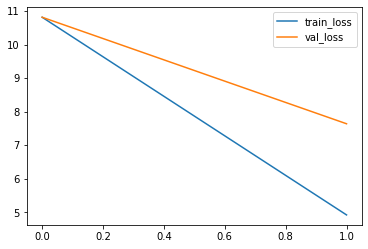

In [6]:
pipeline.train_model()

In [7]:
pipeline.perplexity()

100%|██████████| 1035304/1035304 [59:11<00:00, 291.54it/s] 


(76.50194053094972, 4.354531535130592)

In [3]:
pipeline = Pipeline('CONFIG_MODEL_TWEETS.json', load_model_data = False)

In [8]:
pipeline.load_model('models/tweets/tweets.pth')

In [10]:
pipeline.generate(start_text = 'all')

'all of the moderators used is on blame hopes but not trying to get off tomorrow trump is so the really ignores that any accuser is also a serial behaviour and a year old lot is an extension and bad as he be a sport when he says again that makes a whole witness accounts sooner only conversation if you let it we know it would stop isis via get a change its not once true its all left says he would gain cause to vote trump clinton for clowns with two black everyone machines answers trump prob he has his'

In [11]:
pipeline.generate(start_text = 'what')

'what candidates does mike pence kaine sniffling from donald trump isn like he was really fired from the people on the trump campaign trail the women let donald trump say whatever them forget that the other are already more likely are we arent authentic and released the best option the blacks and so let that sink in live take by the highest kind of where that isn not criticize hillary are the most unqualified candidate trump ever qualified to hit a new guccifer election given people including political office via bipartisan report in pause among them they say you are like'

In [12]:
pipeline.generate(start_text = 'i like')

'i like a black americans have girls left against donald trump i make a p he sh every woman you can have to be a woman i will be a wife because it wasnt how his men were measured by the other class by being small amp shouldnt spinning free tax after donald trump im not until any of our democracy so they can with and instead anymore i dont know whats so theyre decisi on monday via youtube donald j trump he may have been married to judge but by him as an angry white man i said he is only'

# Wiki Model

In [6]:
pipeline = Pipeline('CONFIG_MODEL_WIKI.json', load_model_data = True)

100%|██████████| 61/61 [00:01<00:00, 57.66it/s]


  0%|          | 0/79419 [00:00<?, ?it/s]

Train loss at epoch 0 : 10.81245187593375
Eval loss at epoch 0 : 10.812277486954612
updating best metric


100%|██████████| 174/174 [00:00<00:00, 200.67it/s]


Train loss at epoch 1 : 5.108607498030803
Eval loss at epoch 1 : 8.684686896444736
updating best metric


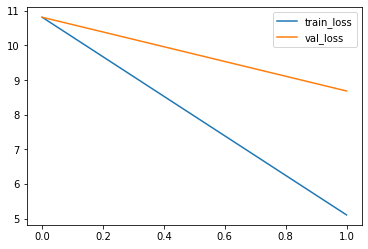

In [7]:
pipeline.train_model()

In [8]:
pipeline.perplexity()

100%|██████████| 1552/1552 [00:07<00:00, 217.94it/s]


(107.89885933974432, 4.684859333886314)

In [13]:
pipeline.generate(start_text = 'all')

'all survive and as a member of the following a series of events.In addition to The Seven Every football team has four owned Winchester buildings as part of national features such as the Red Sox on the games. The financing team teams to the rest of the game ended past.First game was first aired in the Kingdom of the United States on May. A sequel to The Next Generation in November as the lead of the first season was made by before the release of the first date at the National Palace. DVD combat manufacturer released'

In [14]:
pipeline.generate(start_text = 'what')

'what is `` deeply pretty good and losing skill... `` all these were used at the time of the game team. These efforts were done in London creating a only new contact with the rest of the team of a team. followers he did not attend the ceremony in which they scheduled outside of service and a woman s team were able to obtain new rules. The team initially again responded by keeping the rules for the court benefit so to the other other members would be taken to this sheet room. Local member of the'

In [15]:
pipeline.generate(start_text = 'i like')

'i like Santa Jam for at a lesbian band. According to another appeared in the performance that `` the show is the first step the first performance of the music sequences has suggested that the father of need to give her an automobile trademark of an American woman getting the hand of a God of Our Life ``. A press journalist Charles Ellis said that she was facing `` very good `` because of the injury because of hitting the group only for women s partners in the private debates and as Soul Director Jack R. subsequent `` The Great'

In [12]:
d = {
    'train_set_len' : len(pipeline.train_dataset),
    'train_set_tokens' : pipeline.train_dataset.token_len(),
    'val_set_len' : len(pipeline.val_dataset),
    'val_set_tokens' : pipeline.val_dataset.token_len(),
    'test_set_len' : len(pipeline.test_dataset),
    'test_set_tokens' : pipeline.test_dataset.token_len(),
}

## FedSGD

In [1]:
from src.federated_pipeline import Federated_SGD

In [2]:
federated = Federated_SGD(
    "CONFIG_MODEL_TWEETS.json",
    "CONFIG_FEDERATED_TWEETS.json",
    testing = True
)

  0%|          | 0/100 [00:00<?, ?it/s]

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


In [3]:
federated.train(10, save_results = True, plt_name = 'test_o')

 30%|██▉       | 66/221 [00:00<00:00, 212.22it/s]


 64%|██████▍   | 88/137 [00:00<00:00, 212.08it/s]


 52%|█████▏    | 88/169 [00:00<00:00, 212.91it/s]


 22%|██▏       | 22/100 [01:19<03:28,  2.67s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 31%|███       | 31/100 [01:41<02:46,  2.41s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 41%|████      | 41/100 [02:01<01:44,  1.77s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 42%|████▏     | 42/100 [02:02<01:35,  1.65s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 75%|███████▌  | 75/100 [03:02<00:44,  1.76s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 87%|████████▋ | 87/100 [03:22<00:22,  1.76s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 0/100 [00:00<?, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  1%|          | 1/100 [00:13<21:56, 13.29s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 12%|█▏        | 12/100 [00:53<04:24,  3.01s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 27%|██▋       | 27/100 [01:30<02:46,  2.28s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 36%|███▌      | 36/100 [01:52<02:40,  2.51s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 42%|████▏     | 42/100 [02:02<01:35,  1.65s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 75%|███████▌  | 75/100 [03:02<00:44,  1.77s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 87%|████████▋ | 87/100 [03:22<00:22,  1.76s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 91%|█████████ | 91/100 [03:28<00:14,  1.61s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


  1%|          | 1/100 [00:13<22:07, 13.41s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 11%|█         | 11/100 [00:53<04:46,  3.22s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 27%|██▋       | 27/100 [01:35<02:56,  2.42s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 35%|███▌      | 35/100 [01:56<02:46,  2.56s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 42%|████▏     | 42/100 [02:09<01:41,  1.75s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 75%|███████▌  | 75/100 [03:13<00:47,  1.89s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 87%|████████▋ | 87/100 [03:35<00:24,  1.89s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 0/100 [00:00<?, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  1%|          | 1/100 [00:14<23:26, 14.20s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


  5%|▌         | 5/100 [00:35<09:23,  5.93s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 15%|█▌        | 15/100 [01:05<04:05,  2.88s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 31%|███       | 31/100 [01:47<02:56,  2.55s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 41%|████      | 41/100 [02:08<01:51,  1.89s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 42%|████▏     | 42/100 [02:10<01:42,  1.76s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 75%|███████▌  | 75/100 [03:13<00:47,  1.90s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 87%|████████▋ | 87/100 [03:35<00:24,  1.89s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 0/100 [00:00<?, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  1%|          | 1/100 [00:14<23:22, 14.16s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


  5%|▌         | 5/100 [00:35<09:24,  5.94s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 15%|█▌        | 15/100 [01:05<04:05,  2.89s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 31%|███       | 31/100 [01:47<02:56,  2.56s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 41%|████      | 41/100 [02:09<01:51,  1.89s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 42%|████▏     | 42/100 [02:10<01:42,  1.76s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 75%|███████▌  | 75/100 [03:14<00:47,  1.90s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 87%|████████▋ | 87/100 [03:35<00:24,  1.88s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 0/100 [00:00<?, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  1%|          | 1/100 [00:14<23:25, 14.20s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 11%|█         | 11/100 [00:53<04:43,  3.18s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 27%|██▋       | 27/100 [01:36<02:58,  2.45s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 35%|███▌      | 35/100 [01:57<02:47,  2.58s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 42%|████▏     | 42/100 [02:10<01:41,  1.76s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 75%|███████▌  | 75/100 [03:14<00:47,  1.88s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 87%|████████▋ | 87/100 [03:35<00:24,  1.89s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 0/100 [00:00<?, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  1%|          | 1/100 [00:14<23:22, 14.16s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


  5%|▌         | 5/100 [00:35<09:24,  5.94s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 15%|█▌        | 15/100 [01:05<04:05,  2.89s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 31%|███       | 31/100 [01:47<02:56,  2.56s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 41%|████      | 41/100 [02:09<01:51,  1.88s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 42%|████▏     | 42/100 [02:10<01:41,  1.76s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 75%|███████▌  | 75/100 [03:13<00:47,  1.89s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 88%|████████▊ | 88/100 [03:36<00:20,  1.71s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 0/100 [00:00<?, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  1%|          | 1/100 [00:14<23:24, 14.19s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 12%|█▏        | 12/100 [00:57<04:39,  3.17s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 27%|██▋       | 27/100 [01:36<02:57,  2.43s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 36%|███▌      | 36/100 [02:00<02:53,  2.72s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 42%|████▏     | 42/100 [02:10<01:42,  1.76s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 75%|███████▌  | 75/100 [03:14<00:46,  1.87s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 87%|████████▋ | 87/100 [03:35<00:24,  1.88s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 0/100 [00:00<?, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  1%|          | 1/100 [00:14<23:27, 14.22s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 11%|█         | 11/100 [00:53<04:32,  3.06s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 27%|██▋       | 27/100 [01:33<02:50,  2.33s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 35%|███▌      | 35/100 [01:53<02:40,  2.46s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 41%|████      | 41/100 [02:04<01:46,  1.80s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 42%|████▏     | 42/100 [02:06<01:37,  1.68s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 76%|███████▌  | 76/100 [03:08<00:43,  1.83s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 88%|████████▊ | 88/100 [03:29<00:20,  1.68s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 0/100 [00:00<?, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  1%|          | 1/100 [00:14<23:24, 14.18s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 12%|█▏        | 12/100 [00:56<04:36,  3.15s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 27%|██▋       | 27/100 [01:36<03:02,  2.50s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 36%|███▌      | 36/100 [01:59<02:48,  2.64s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 42%|████▏     | 42/100 [02:09<01:42,  1.77s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 75%|███████▌  | 75/100 [03:12<00:45,  1.81s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 87%|████████▋ | 87/100 [03:32<00:23,  1.80s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


100%|██████████| 6024/6024 [00:07<00:00, 754.29it/s]


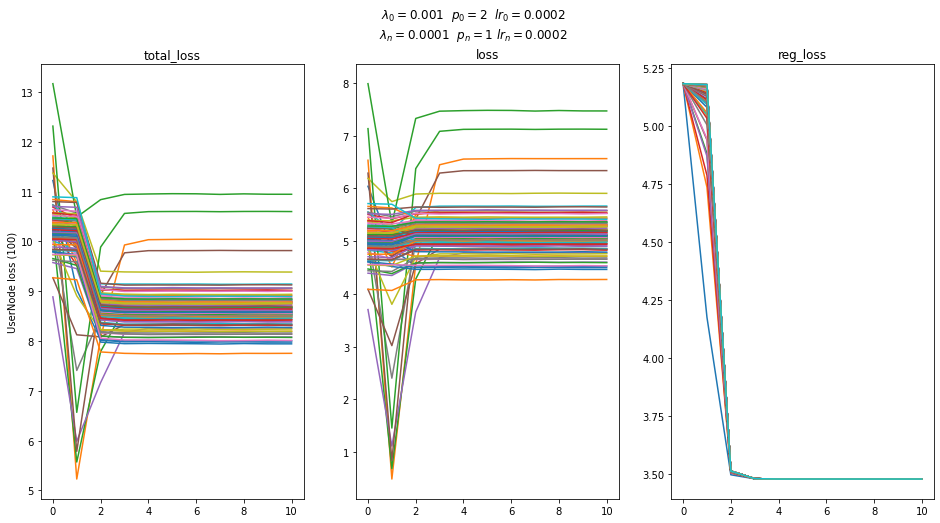

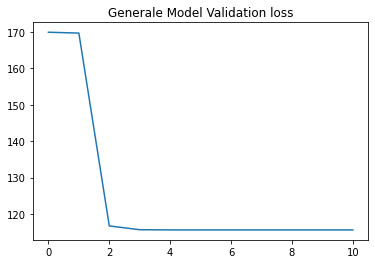

In [4]:
federated.plot_training_history(save_results=False, plt_name = '')

## FedAVG

In [ ]:
from src.federated_pipeline import Federated_LICCHAVI

In [ ]:
federated = Federated_LICCHAVI(
    "CONFIG_MODEL_WIKI.json",
    "CONFIG_FEDERATED_WIKI.json"
)

In [ ]:
federated.train(2)